In [4]:
import torch
import math
from SC_IPFP.torch.utils import NN, log_kde_pdf_per_point, silvermans_rule
from SC_IPFP.torch.sde_solvers_time import solve_sde_RK


from tqdm.notebook import tqdm



import itertools
from functools import partial
# np = jax.numpy
import matplotlib.pyplot as plt

In [21]:
from torch import nn
class NN(nn.Module):

    def __init__(self, input_dim=1,  weight_dim_list=[20,20,20]):
        super(NN, self).__init__()

        self.weight_dim_list = [input_dim] + weight_dim_list
        self.layers = [None for i in weight_dim_list]

        for i in range(len(weight_dim_list)):
            setattr(
                self,
                "f" + str(i),
                nn.Linear(
                    self.weight_dim_list[i], self.weight_dim_list[i + 1],
                    bias=True
                )
            )
            self.layers[i]  = getattr(self, "f" + str(i))

            torch.nn.init.xavier_uniform(self.layers[i].weight)
    
    def get_var(self , other=None):
        return torch.tensor([[0]]).double()

    def forward(self, x, var=None):
        functerino = torch.nn.functional.softplus
        x_ = x.clone()
        for i_, layer in enumerate(self.layers[:-1]):
            try:
                x = functerino(layer(x))
            except:
                print(x.shape, i_, x_.shape)
                import pdb; pdb.set_trace()
                raise
        try:
            return (self.layers[-1](x))
        except:
            import pdb; pdb.set_trace()
            raise


In [22]:
def solve_sde_RK(alfa=None, beta=None, X0=None, dt=1.0, N=100, t0=0.0,
                theta=None, noise=False, forwards=True):
    """
            Euler Mayurama method
    Syntax:
    ----------
    solve_sde(alfa=None, beta=None, X0=None, dt=None, N=100, t0=0, DW=None)
    Parameters:
    ----------
        alfa  : a  function with two arguments, the X state and the time
                defines the differential equation.
        beta  : a  function with two arguments, the X state and the time
                defines the stochastic part of the SDE.
        X0    : Initial conditions of the SDE. Mandatory for SDEs
                with variables > 1 (default: gaussian np.random)
        dt    : The timestep of the solution
                (default: 1)
        N     : The number of timesteps (defines the length of the timeseries)
                (default: 100)
        t0    : The initial time of the solution
                (default: 0)
    
    """
    
#     print(X0)
       
    if alfa is None or beta is None:
        raise ValueError("Error: SDE not defined.")

    n, d, *_ = X0.shape
    
    T = torch.tensor(dt * N).cuda()
    
    DWs  = torch.empty((n, N-1, d)).normal_(mean=0, std=1).cuda() * math.sqrt(dt)
    
    
    Y, ti = torch.zeros((n, N, d + 1)).double().cuda(), torch.arange(N).double().cuda()*dt + t0
    t0rep =  (
        t0 * torch.ones((X0.shape[0], 1)).double().cuda() if forwards
        else (T-t0) * torch.ones((X0.shape[0], 1)).double().cuda()
    )
#     Y[:, 0, :] =  torch.cat((X0, t0rep), axis=1 )
    ixs = torch.arange(3, dtype=torch.int64)
    Y = torch.cat((X0, t0rep), axis=1 )[:, None, :]

    N = int(N)
    
    T = dt * N
        
    for n in range(N-1):
        t = ti[n]
        a, DW_n = alfa(Y[:,n, :]),  DWs[:,n,:]
        newY = (  
            Y[:,n, :-1] + a * dt + beta * DW_n
        )
        
        trep = (
            t.repeat(newY.shape[0]).reshape(-1,1) if forwards
            else T - t.repeat(newY.shape[0]).reshape(-1,1)
        )
        
        tocat = torch.cat((newY, trep), dim=1)[:, None, :]
        Y = torch.cat((Y,tocat) , dim=1)
        if torch.isnan(Y).any() or torch.isinf(Y).any(): import pdb; pdb.set_trace()
#     import pdb; pdb.set_trace()
    return ti, Y

In [23]:
class cIPFP(object):
    
    def __init__(self, X_0, X_1, weights=[100], batch_size=None,  rng = None, rng_b = None, 
                nrng = None, number_time_steps=16, sde_solver=solve_sde_RK, sigma_sq=1, 
                step_size = 0.001, num_epochs = 10, momentum_mass = 0.9, create_network=None,
                log_prob=log_kde_pdf_per_point, optimizer=torch.optim.SGD):
        
        self.sde_solver = sde_solver
        
        self.number_time_steps = number_time_steps
        self.dt = 1.0 / number_time_steps
        
        
        self.batch_size_f = X_0.shape[0] if batch_size is None else batch_size
        self.batch_size_b = X_1.shape[0] if batch_size is None else batch_size
        with torch.cuda.device(0):
        
            self.X_0 = X_0
            self.X_1 = X_1

            self.H_0 = silvermans_rule(X_0)
            self.H_1 = silvermans_rule(X_1)

            _, self.dim = self.X_0.shape

            weights = weights + [self.dim]


            self.b_forward = NN(self.dim + 1, weights).double().cuda()
            self.b_backward = NN(self.dim + 1, weights).double().cuda()

            self.theta_f = list(self.b_forward.parameters())
            self.theta_b = list(self.b_backward.parameters())

            self.sigma = sigma_sq

            self.optimizer_f = optimizer(
                self.theta_f, lr=step_size
            )

            self.optimizer_b = optimizer(
                self.theta_b, lr=step_size
            )

            num_complete_batches_f, leftover_f = divmod(self.X_0.shape[0], self.batch_size_f)
            self.num_batches_f = num_complete_batches_f + bool(leftover_f)

            num_complete_batches_b, leftover_b = divmod(self.X_1.shape[0], self.batch_size_b)
            self.num_batches_b = num_complete_batches_b + bool(leftover_b)

            self.first_iter_fac = 0.0

            self.log_prob = log_prob

            self.burn_in = False
    
    def data_stream(self, forward=True):
        X = self.X_0 if forward else self.X_1
        
        batch_size = self.batch_size_f if forward else self.batch_size_b
        num_batches = self.num_batches_f if forward else self.num_batches_b
        
        num_train = self.X_0.shape[0] if forward else self.X_1.shape[0]
        while True:
            perm = torch.randperm(X.size()[0])
            for i in range(num_batches):
                batch_idx = perm[i * batch_size:(i + 1) * batch_size]
                yield X[batch_idx] 
        
    def loss_for_trajectory(self, Xt, forwards):
        n_, *_ = Xt.shape
        
        if not forwards :
            Xt = Xt.flip(1)
        
        if forwards:
            b_minus  = self.b_backward.forward( Xt)
            b_plus = self.b_forward.forward(Xt)
        else:
            b_minus  = self.first_iter_fac * self.b_backward.forward(Xt)
            b_plus = self.b_forward.forward(Xt)

            
        delta_Xt = Xt[:, 1:, :] - Xt[:, :-1, :]  
        
        sign = 1.0 if forwards else -1.0
        
        ito_integral = sign *  (b_plus[:, :-1,:] - b_minus[:, 1:,:])  * delta_Xt
        
        time_integral = sign *  (b_plus**2 - b_minus**2) * self.dt 
        
        out =  ito_integral.sum(axis=(1,2)) - 0.5 * time_integral.sum(axis=(1,2))
        
        return out


    def inner_loss_jit(self, batch,  
                       batch_terminal_empirical,
                       H,  forwards):
        
        b = (
            self.b_forward.forward
            if forwards else (lambda X: -self.b_backward.forward(X))
        )
        
        t, Xt, *W = self.sde_solver(
            b, self.sigma, batch, self.dt, 
            self.number_time_steps, 0,
            None, False, forwards
        )
        Ht = silvermans_rule(Xt[:,-1,:-1])
        H = silvermans_rule(batch_terminal_empirical)
        
        main_term = self.loss_for_trajectory(Xt, forwards)
#         entropy = 0 #-log_kde_pdf_per_point(Xt[:,-1,:-1], Xt[:,-1,:-1], Ht) *  0
        if not self.burn_in:
            cross_entropy = -self.log_prob( Xt[:,-1,:-1], batch_terminal_empirical, H)             
        else:
            cross_entropy = -self.log_prob(batch_terminal_empirical, Xt[:,-1,:-1], Ht)
#             main_term = 0 

        J = torch.mean(main_term + 2.0 * cross_entropy )
        J = torch.squeeze(J)
        return J
    
    def inner_loss(self, batch, forwards=True):
        
        if self. burn_in:
            self.batch_terminal_empirical_burn = next(self.data_stream(forward=forwards))
            self.H_burn = self.H_0 if forwards else self.H_1
#         else:
        batch_terminal_empirical = next(self.data_stream(forward=not(forwards)))
        H = self.H_1 if forwards else self.H_0

        return self.inner_loss_jit(
            batch, batch_terminal_empirical,
            H,  forwards
        )

    def closure(self, X, forwards=True):
        """
        Close method required for pytorches CG and LBFGS optimizers
        :params X[torch.tensor]: nxdim  torch tensor representing dataset
        """
        
        opt = self.optimizer_f if forwards else self.optimizer_b
        
        opt.zero_grad()
        loss = self.inner_loss(X, forwards)
        loss.backward()
        return loss
    
    
    def fit(self, IPFP_iterations=10, sub_iterations=10, plot=False, burn_iterations=7):     
        
        name = str(self.optimizer_f).lower()
        bfgs_cg_flag  = "bfgs" in name or "cg" in name
        close_f, close_b =  [], []

        
        
        if plot: self.plot_trajectories()
        
        self.first_iter_fac = 0.0
        if burn_iterations > 0 : self.burn_in = True
            
        
        batches_f = self.data_stream(forward=True)
        batches_b = self.data_stream(forward=False)
        
        loss_b, loss_f = [], []
        for i in tqdm(range(IPFP_iterations + burn_iterations)):
            
            if i == burn_iterations:
                self.burn_in = False
                self.first_iter_fac = 0.0
            
            
            for k in range(sub_iterations):
                for _ in range(self.num_batches_b):
                    batch_b =  next(batches_b)
                    
                    if bfgs_cg_flag:
                        close_b = [lambda : self.closure(batch_b, False)]
                    lossb = self.inner_loss(
                        batch_b, False
                    )
                    lossb.backward()
                    self.optimizer_b.step(*close_b)
                print(f"loss b {lossb}")
            loss_b.append(lossb)

            self.first_iter_fac = 1.0
       
            for k in range(sub_iterations):
                for _ in range(self.num_batches_f):
                    batch_f =  next(batches_f)
                    if bfgs_cg_flag:
                        close_f = [lambda : self.closure(batch_f, True)]
                    lossf = self.inner_loss(
                        batch_f, True
                    )
                    
                    lossf.backward()
                    self.optimizer_f.step(*close_f)
  
                print(f"loss f {lossf}")
            loss_f.append(lossf)


            self.loss_f = loss_f
            self.loss_b = loss_b
            if plot: self.plot_trajectories()

        
        plt.plot(range(IPFP_iterations), loss_f, "g")
        plt.show()
        plt.plot(range(IPFP_iterations), loss_b, "b")
        plt.show()
        
    def plot_trajectories(self):
        bb = lambda X: -self.b_backward(X)

        t, Xts = c.sde_solver(
            self.b_forward.forward, self.sigma,
            self.X_0, self.dt,  self.number_time_steps, 0.0,
            self.theta_f, False, True
        )
        t_, Xts_ = c.sde_solver(
            bb, self.sigma, 
            self.X_1, self.dt, self.number_time_steps, 0.0, 
            self.theta_b, False, False
        )
        
        fn = 14
        fig, axs = plt.subplots(2,1,  sharey=False, figsize=(15,10))
        axs[1].set_xlabel("$t$", fontsize=fn)
        axs[1].set_ylabel("$x(t)$", fontsize=fn)
        axs[0].set_ylabel("$x(t)$", fontsize=fn)

        tt = axs[1].get_xticks()
        axs[1].set_xticks(tt.flatten() )
        axs[1].set_xticklabels(list(map (lambda x: '{0:.2f}'.format((x)), tt))[::-1])

        for i in range(n):
            label = "$\mathbb{Q}$: Forward process" if i == 0 else None
            axs[0].plot(t.cpu().flatten(), Xts[i,:,:-1].detach().cpu().numpy().flatten(), 'b', alpha=0.03,  label=label)


        for i in range(n):
            label = "$\mathbb{P}$: Reverse process" if i == 0 else None
            axs[1].plot(t_.cpu().flatten(), Xts_[i,:, :-1].detach().cpu().numpy().flatten(), 'r', alpha=0.03, label=label)

        axs[1].legend(fontsize=fn)
        axs[0].legend(fontsize=fn)

        plt.show()    
    
    #     @partial(jit, static_argnums=(0,2))
    def transport_batch(self, batch_x, forwards):
        theta = self.theta_f if forwards else self.theta_b    
        b = self.b_forward if forwards else  lambda X, theta: -self.b_backward(X, theta)

        t, Xt = self.sde_solver(
            alfa=b, beta=self.sigma, dt=self.dt, 
            X0=batch_x.reshape(-1,self.dim), N=self.number_time_steps, theta=theta
        )

        return Xt[:,-1,:]
            

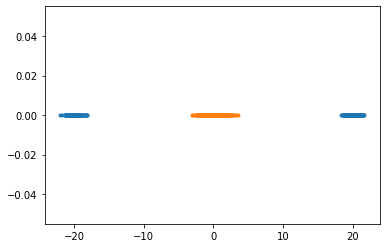

In [24]:
import numpy.random as npr
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

n = 900
n_2 = int(n * 1.0 / 3)

X1 = npr.randn(n).reshape(-1,1) - 0
X21 = 0.6 * npr.randn(n_2).reshape(-1,1) + 20
X22 =  0.6 * npr.randn(n_2).reshape(-1,1) -20
X23 =  0.6 * npr.randn(n_2).reshape(-1,1) + 20

X2 = np.concatenate((X21, X22, X23), axis=0)
# X1, X2 = X2, X1

plt.plot(X2.flatten(), [0] * n, '.')
plt.plot(X1.flatten(), [0] * n, '.')

with torch.cuda.device(0):

    X1 = torch.tensor(X1).cuda()
    X2 = torch.tensor(X2).cuda()

In [27]:
c = cIPFP(
    X1, X2,  number_time_steps=100, batch_size=900 ,
    step_size = 1e-4, weights=[40, 40, 40], rng = None, optimizer=torch.optim.Adagrad
)

/anaconda/envs/py37_default/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


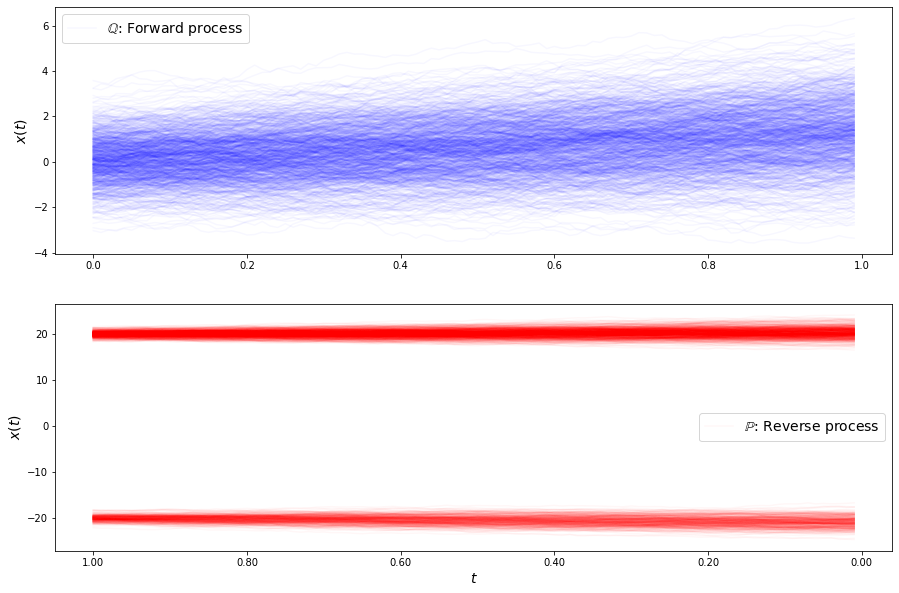

loss b 116.0571946676087
loss b 106.43937490807973
loss b 118.60485583052026
loss b 115.25219749437592
loss b 116.38657421651297
loss b 103.08415864162535
loss b 114.6256180838044
loss b 114.82433045415696
loss b 117.91700637488856
loss b 113.89076377393546
loss b 116.14239886780528
loss b 111.14772419754763
loss b 112.82655564672973
loss b 116.80477400467481
loss b 112.24942314523318
loss b 115.03776092646135
loss b 109.7632633868583
loss b 112.19663191374262
loss b 116.18284630726389
loss b 115.39089312415
loss b 114.96518180029068
loss b 112.33019837874303
loss b 113.52733757725726
loss b 116.31263402137807
loss b 115.02161405671264
loss b 114.8896385934438
loss b 117.00770951836874
loss b 112.13393606242634
loss b 115.29228657660269
loss b 114.39191042106435
loss b 110.67072870800983
loss b 113.37581185030075
loss b 110.41116084719724
loss b 98.90092322995014
loss b 110.92659487784202
loss b 111.25001783842154
loss b 113.14723494633908
loss b 110.856909645543
loss b 114.49181224800

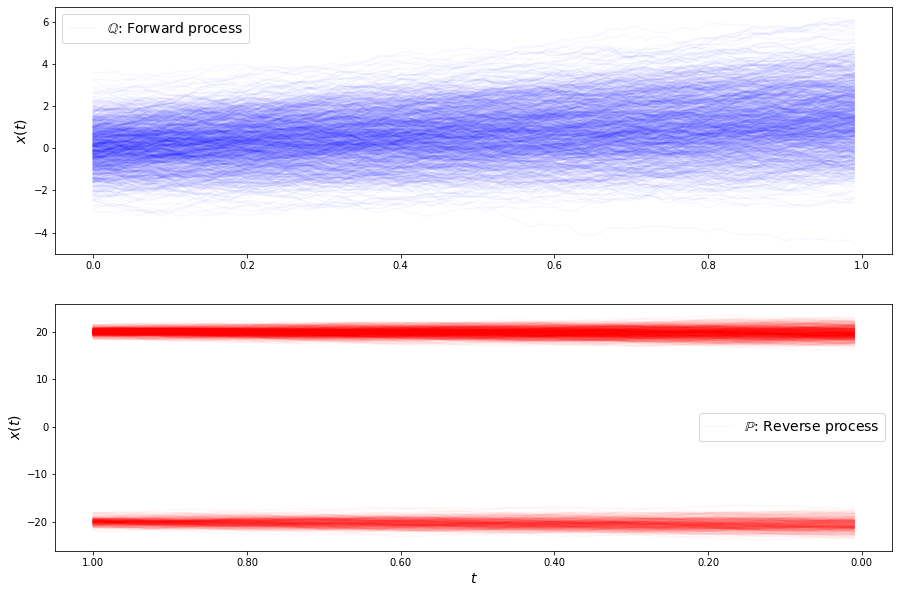

loss b 112.02762483137109
loss b 117.62108827544488
loss b 114.3526958523187
loss b 113.25105109603786
loss b 115.20823330347959
loss b 116.00367096691059
loss b 117.22982033608997
loss b 119.52790406929132
loss b 117.65085232046484
loss b 114.1394303700513
loss b 111.34598346624068
loss b 119.22906121134687
loss b 108.30742106889195
loss b 114.36208014358692
loss b 115.63041322817998
loss b 115.90638962318705
loss b 112.18851618592187
loss b 114.8462557606734
loss b 111.42476937507675
loss b 112.05494858270718
loss b 112.9526188497979
loss b 111.4985152062202
loss b 109.44095189645317
loss b 112.47554560547802
loss b 116.00486311474442
loss b 116.15657954643731
loss b 97.96564623076242
loss b 118.93237258821588
loss b 112.63867953384272
loss b 114.05959326564627
loss b 111.75626863300792
loss b 111.69824277663358
loss b 113.55233002126936
loss b 102.74191598525317
loss b 112.61867821691054
loss b 107.40598450979367
loss b 112.44940548445301
loss b 117.3952825820135
loss b 109.80124337

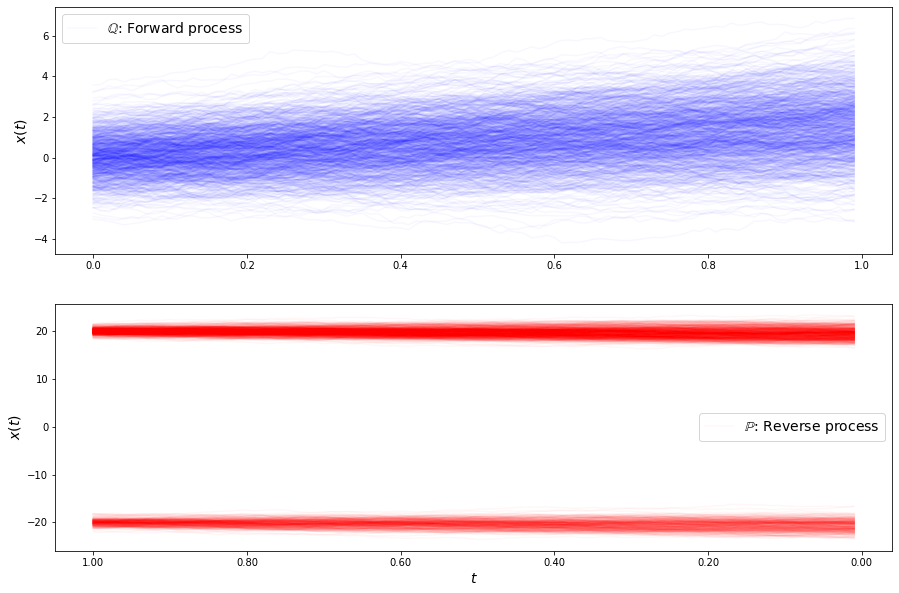

loss b 115.09136238305422
loss b 94.63016691075639
loss b 115.92103250231061
loss b 116.80955950017264
loss b 113.70797127455828
loss b 113.25768649434517
loss b 116.39283365012245
loss b 108.09532059888124
loss b 112.3441008440159
loss b 108.8001062820685
loss b 109.18271302666273
loss b 114.74652260255678
loss b 110.38228334600488
loss b 114.2060564017772
loss b 114.70247414785284
loss b 105.59767994269919
loss b 115.44586698754746
loss b 113.08527669326755
loss b 113.4723320509251
loss b 113.40105345159532
loss b 116.70438536988941
loss b 114.61871778454052
loss b 110.95296222702694
loss b 117.31403891379082
loss b 106.8059014982036
loss b 109.53095451920001
loss b 111.28643251109676
loss b 101.53352132356515
loss b 110.12048203050593
loss b 108.94793812608839
loss b 111.13342119480878
loss b 113.32714762943704
loss b 111.9360545569394
loss b 111.83920461989597
loss b 109.04041849683519
loss b 114.22462183100413
loss b 111.2221578568667
loss b 108.31302644226416
loss b 114.030332147

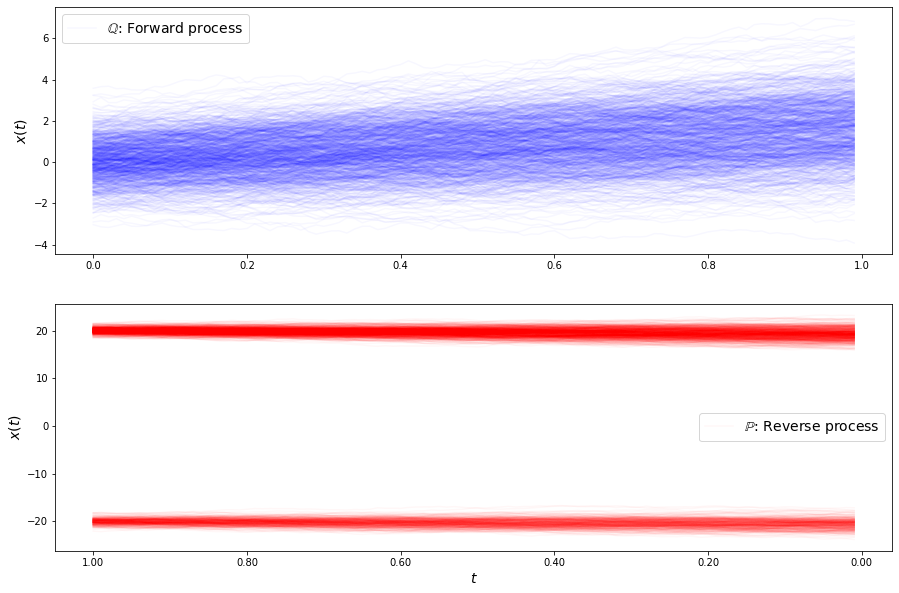

loss b 114.01234720829883
loss b 107.13236743235966
loss b 108.7847323404155
loss b 111.165702970499
loss b 112.61742958168374
loss b 116.36256125528044
loss b 113.96511478676385
loss b 112.59361018048124
loss b 118.76968399371545
loss b 100.21135340068398
loss b 114.5904207410992
loss b 114.04220851400802
loss b 112.45218094715366
loss b 109.30388021046815
loss b 110.52087807539338
loss b 102.83156388958446
loss b 115.00314268332338
loss b 105.78131080149535
loss b 105.08368363491329
loss b 112.22647985597403
loss b 112.5810143458408
loss b 113.04710563522113
loss b 111.787267133972
loss b 111.97078251832248
loss b 111.3042044639756
loss b 110.23205856888018
loss b 107.47498489620376
loss b 107.81390406358905
loss b 110.86543304936043
loss b 107.41397576885518
loss b 110.78898415164328
loss b 107.69897108301289
loss b 112.09282910690312
loss b 109.54652055621838
loss b 108.68604672897351
loss b 108.62878960259754
loss b 110.66726430430926
loss b 111.64385112355183
loss b 111.956953534

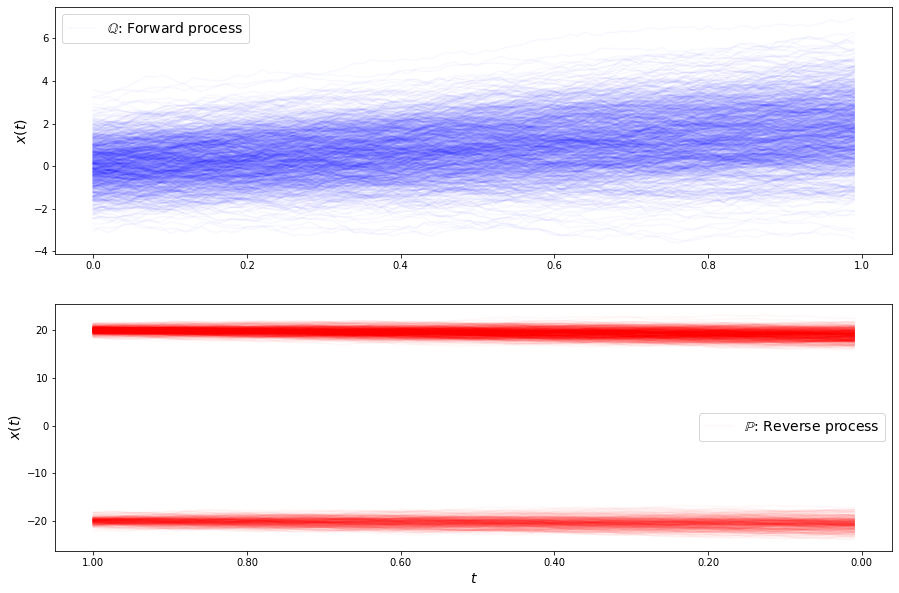

loss b 113.97397255445483
loss b 113.60842721932929
loss b 109.82093910463607
loss b 108.45335518620658
loss b 109.61345002817731
loss b 112.5514931629892
loss b 109.89933303724602
loss b 113.04919518223673
loss b 112.37778431690207
loss b 102.09506862325476
loss b 116.36191455063285
loss b 111.36949672567067
loss b 109.61778902300452
loss b 112.84094652452579
loss b 99.28472922830579
loss b 114.21887841204948
loss b 106.87471388696889
loss b 115.2730456203259
loss b 105.20198199729433
loss b 112.30456510921128
loss b 113.1668872110709
loss b 110.60665879912601
loss b 112.49853852976817
loss b 107.18532637719846
loss b 107.7329854524571
loss b 114.63700777556693
loss b 108.54715986905524
loss b 110.28187410219816
loss b 111.17400789269644
loss b 112.05728355996196
loss b 109.26872409608279
loss b 106.49539821771207
loss b 113.73291460894731
loss b 111.96030383163588
loss b 106.47550395546207
loss b 108.64434512874486
loss b 104.37114030806416
loss b 108.72968858647461
loss b 106.117859

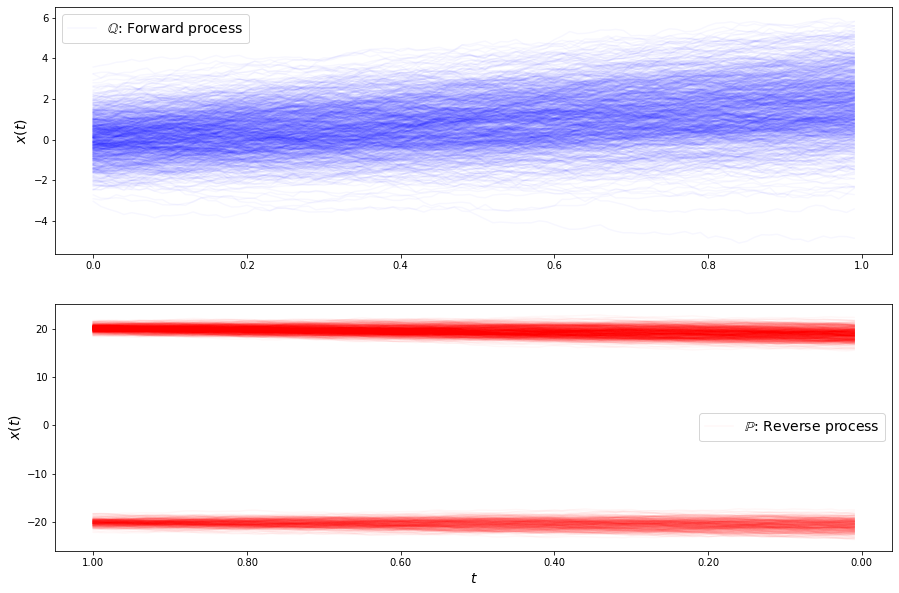

loss b 1912.7086683959635
loss b 1905.77303536493
loss b 1916.6285509386246
loss b 1914.9756235484986
loss b 1889.039410593944
loss b 1917.003784700363
loss b 1896.8713849950989
loss b 1908.7356970250014
loss b 1901.954325627024
loss b 1893.2200158061153
loss b 1910.4474505257408
loss b 1912.349616586648
loss b 1897.7225392167468
loss b 1882.294084185538
loss b 1898.1378790737656
loss b 1898.1022042656393
loss b 1885.4622658980027
loss b 1890.0208474083206
loss b 1869.8174599678587
loss b 1883.0390977611476
loss b 1883.630799319691
loss b 1879.9140673944191
loss b 1878.1079555284912
loss b 1871.985835070174
loss b 1868.0629504050014
loss b 1875.2538884204657
loss b 1879.9216012317784
loss b 1859.209306186804
loss b 1860.6021593649918
loss b 1849.1602531621706
loss b 1861.4242708228746
loss b 1863.5648748405308
loss b 1846.0698702385685
loss b 1853.4051691253742
loss b 1863.6800813892125
loss b 1863.6336550820085
loss b 1841.3606584391848
loss b 1854.2009977418304
loss b 1833.1016640256

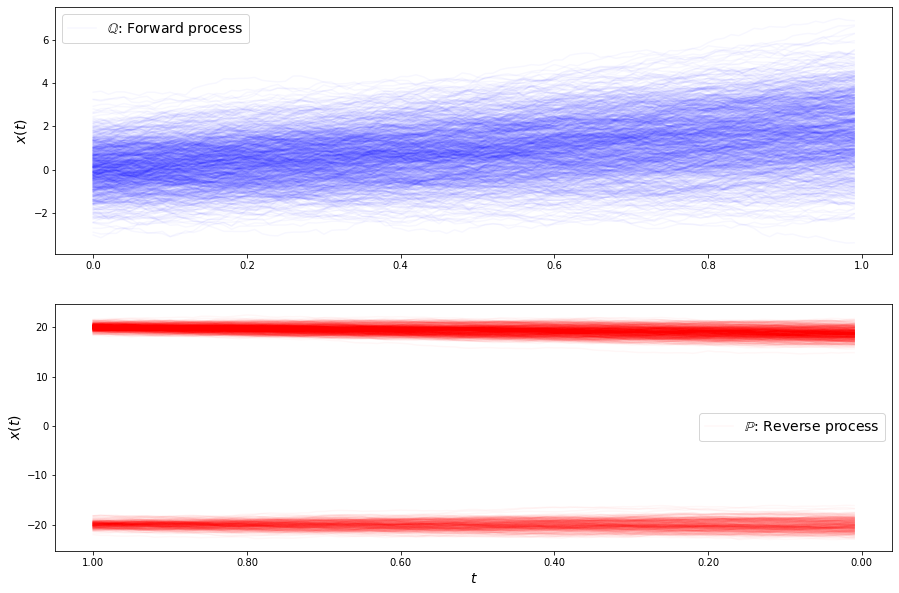

loss b 1852.8767652411314
loss b 1851.4467767525723
loss b 1865.148860403916
loss b 1848.0451413384014
loss b 1837.2065606001868
loss b 1840.9094899109668
loss b 1852.1024796248394
loss b 1850.8101157184547
loss b 1835.723183948415
loss b 1836.992708235004
loss b 1837.6319450128308
loss b 1835.5719948016308
loss b 1835.566864407908
loss b 1836.8591945333533
loss b 1830.1941270826323
loss b 1814.7746105660947
loss b 1830.9288940396664
loss b 1818.0223709875052
loss b 1826.5348309723531
loss b 1817.9550663968366
loss b 1825.8884316910066
loss b 1812.1600147358618
loss b 1811.9935034170308
loss b 1829.6274036151349
loss b 1808.924468035193
loss b 1806.2355955849919
loss b 1806.7457931922827
loss b 1800.3435258873437
loss b 1813.4497749644727
loss b 1818.8513002014392
loss b 1803.453172333323
loss b 1813.8690511198022
loss b 1802.8547620665897
loss b 1800.5979054189556
loss b 1817.5090391092942
loss b 1791.439798209086
loss b 1803.2841832931276
loss b 1802.0688252097425
loss b 1803.7642141

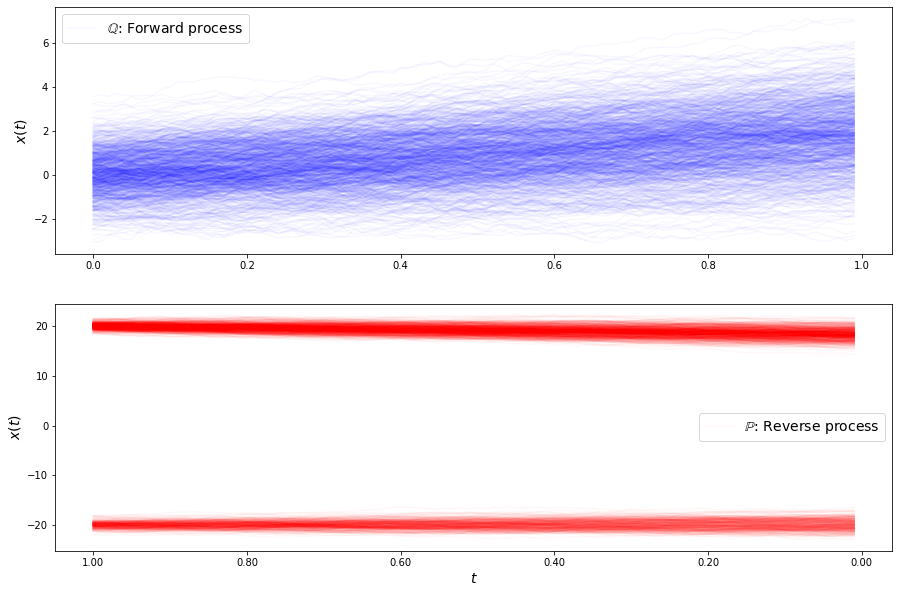

loss b 1796.167064725239
loss b 1793.8806450257405
loss b 1799.891565223123
loss b 1805.6972018120712
loss b 1802.203635507759
loss b 1790.5945659730803
loss b 1791.4930749472337
loss b 1800.6539521509094
loss b 1782.7830456585518
loss b 1790.1621186470973
loss b 1781.448423631744
loss b 1791.8397728349667
loss b 1771.0829712716989
loss b 1774.9952872881418
loss b 1772.0715746149476
loss b 1774.3607883950901
loss b 1782.6803087246817
loss b 1780.062976334673
loss b 1790.6698885752323
loss b 1783.272070384474
loss b 1758.975563984717
loss b 1772.499976551351
loss b 1772.2533121399802
loss b 1774.172117292721
loss b 1773.6499292262615
loss b 1774.3554462875095
loss b 1779.1621749562485
loss b 1764.709804713324
loss b 1758.9827018406345
loss b 1771.6481480046193
loss b 1766.0280148955046
loss b 1768.3556925762875
loss b 1758.7273379267963
loss b 1773.1610433667965
loss b 1773.673705450611
loss b 1772.0892711570946
loss b 1758.8985733823893
loss b 1750.3520893096588
loss b 1757.34390521175

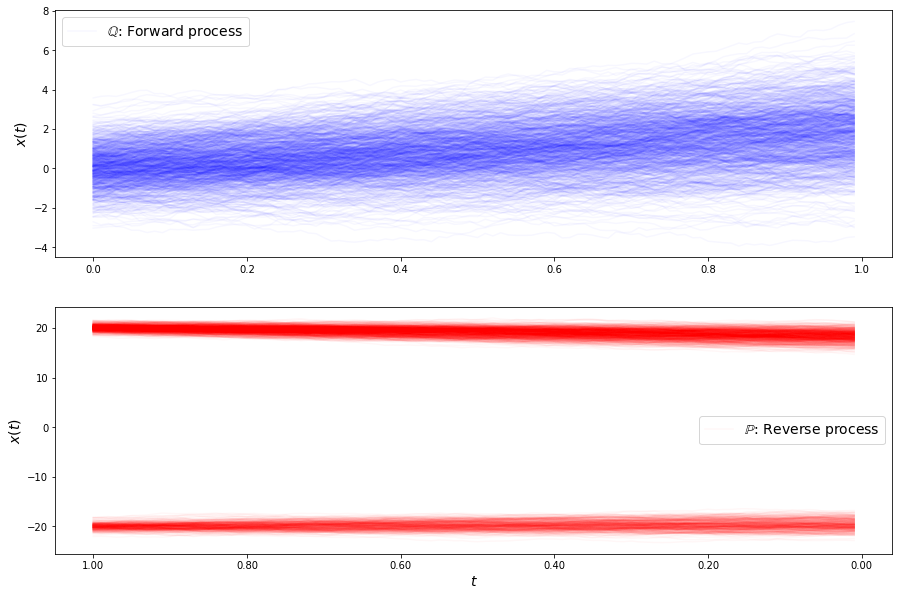

loss b 1763.184347999435
loss b 1761.1693782984257
loss b 1761.678410242811
loss b 1752.681978978604
loss b 1740.7041229145325
loss b 1762.2114883433221
loss b 1749.6388278135482
loss b 1753.8695203934478
loss b 1754.390393773997
loss b 1739.9632367173663
loss b 1751.236573949055
loss b 1750.1824455046094
loss b 1760.246144249264
loss b 1738.1049543520232
loss b 1742.3116178512769
loss b 1740.7052153490633
loss b 1724.298058428563
loss b 1733.978038408478
loss b 1735.6825947237448
loss b 1721.4954775220174
loss b 1743.3744921861896
loss b 1743.9683695123508
loss b 1739.1698899741148
loss b 1726.3575329348791
loss b 1748.1631081612327
loss b 1746.743407612557
loss b 1733.6826857192953
loss b 1725.7735752064725
loss b 1718.9167716769925
loss b 1731.5148893416513
loss b 1723.6577293589087
loss b 1720.3579774847965
loss b 1711.9855186374364
loss b 1712.1257513798862
loss b 1723.3476557047459
loss b 1719.5255933414633
loss b 1729.3851948126287
loss b 1731.9647610237503
loss b 1731.724706403

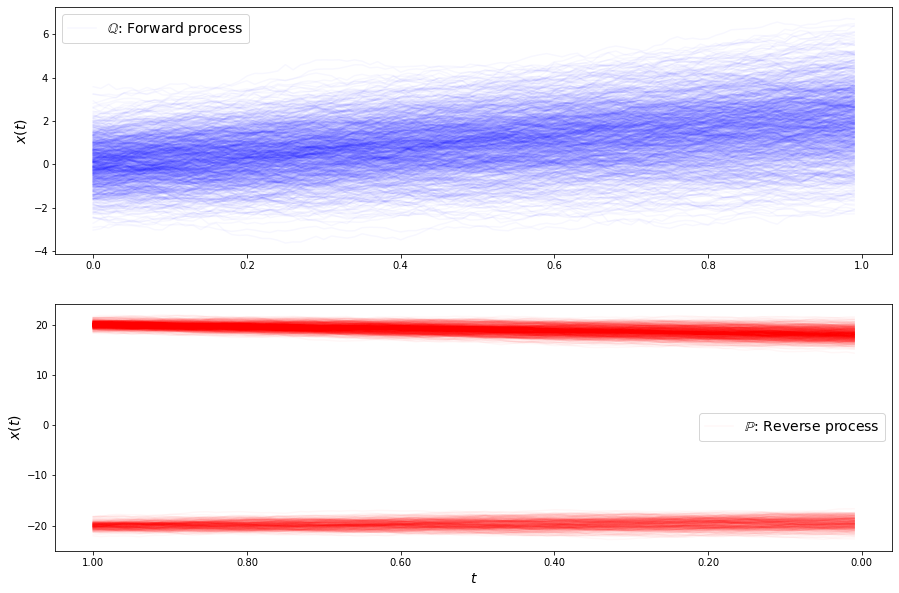

loss b 1722.0473098143848
loss b 1713.4903274077355
loss b 1708.5472142635892
loss b 1725.3069583734289
loss b 1725.875935429344
loss b 1716.9725137859762
loss b 1714.9189475872413
loss b 1721.0262799764967
loss b 1713.3630933764969
loss b 1705.962018241415
loss b 1710.8956446272846
loss b 1710.4190345316151
loss b 1712.8069677621913
loss b 1702.9520764227307
loss b 1711.8346115303266
loss b 1709.592586956596
loss b 1711.4058231386873
loss b 1725.6565600605973
loss b 1695.744706541666
loss b 1715.4998932827461
loss b 1706.42793048105
loss b 1702.9705634409786
loss b 1690.9645705107414
loss b 1710.8595917918346
loss b 1698.0462145434067
loss b 1699.475838684154
loss b 1703.0426115744428
loss b 1699.2996031467908
loss b 1704.53440219265
loss b 1690.8838164652075
loss b 1696.067509836564
loss b 1681.355976301526
loss b 1702.8070023058328
loss b 1701.1273511293234
loss b 1688.7432644910164
loss b 1691.304224666768
loss b 1702.6749243998038
loss b 1691.5678009810463
loss b 1701.472543752593

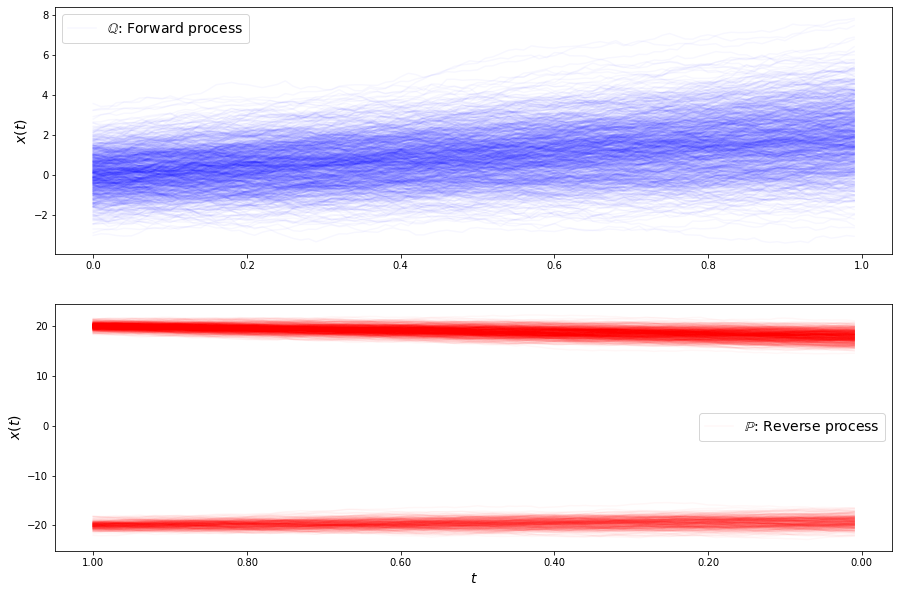

loss b 1679.6866661726492
loss b 1692.9223391948376
loss b 1684.2903031379929
loss b 1690.03794071821
loss b 1680.1409554107122
loss b 1699.2546174885215
loss b 1681.8678256719788
loss b 1682.6793271706815
loss b 1693.25015586758
loss b 1666.1618434190461
loss b 1686.9823029717427
loss b 1682.3979647924862
loss b 1678.1270186534211
loss b 1677.110944897029
loss b 1678.687921959457
loss b 1692.556712013698
loss b 1680.8299831597337
loss b 1676.2348178376749
loss b 1675.049796078227
loss b 1676.1205739097634
loss b 1679.7269721320527
loss b 1672.605482038237
loss b 1689.272684219001
loss b 1677.8472035820944
loss b 1661.8334175264706
loss b 1667.4443909378426
loss b 1686.9832956269163
loss b 1678.6686943162626
loss b 1673.6454180667447
loss b 1679.3158950212355
loss b 1673.852796999362
loss b 1653.1469185493343
loss b 1681.1105187442465
loss b 1673.025552734973
loss b 1669.9089456218935
loss b 1649.0419105959122
loss b 1672.157640227666
loss b 1672.4303187270903
loss b 1658.7790213579158

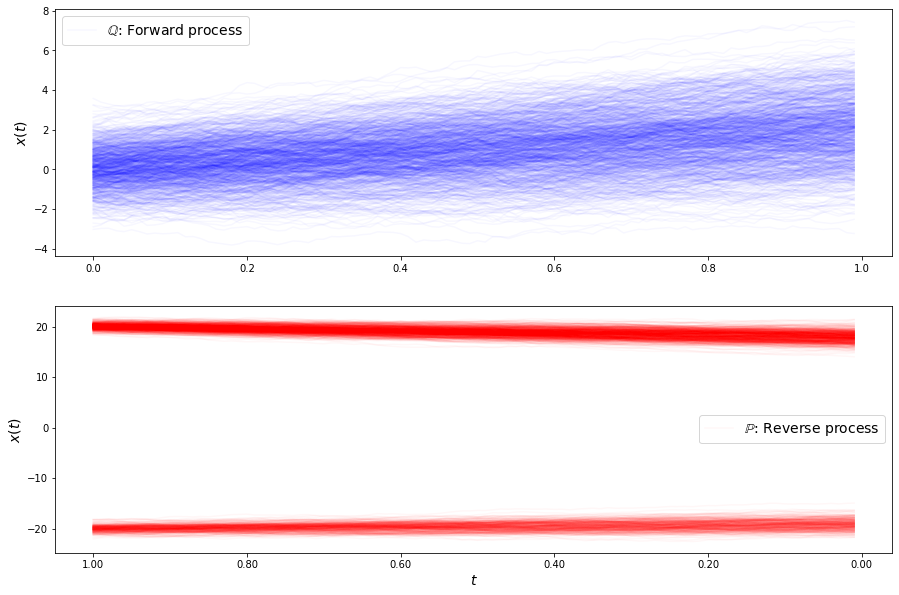

loss b 1676.322181651937
loss b 1658.0729468203415
loss b 1653.952866885247
loss b 1662.8217236597573
loss b 1655.801439819241
loss b 1648.0259139378506
loss b 1667.3625613337213
loss b 1660.968337089408
loss b 1649.451219376248
loss b 1670.3758659699986
loss b 1650.2514844922523
loss b 1656.527662035684
loss b 1660.504821431794
loss b 1659.2272115837864
loss b 1642.123380211018
loss b 1646.6693862040001
loss b 1643.3478225395925
loss b 1652.428181128486
loss b 1655.2670691174505
loss b 1653.5013731133606
loss b 1642.7366396291181
loss b 1648.881161083132
loss b 1660.7086360353123
loss b 1646.5735421456018
loss b 1652.1865454514073
loss b 1649.6183093734307
loss b 1644.978475354718
loss b 1644.6618519516358
loss b 1640.3655243710728
loss b 1643.4053690811943
loss b 1660.2193301200275
loss b 1635.6227247452834
loss b 1639.146363975849
loss b 1635.4943084365827
loss b 1649.7266241097243
loss b 1651.9973875403746
loss b 1641.7247960813907
loss b 1649.0294212751392
loss b 1646.783359761123

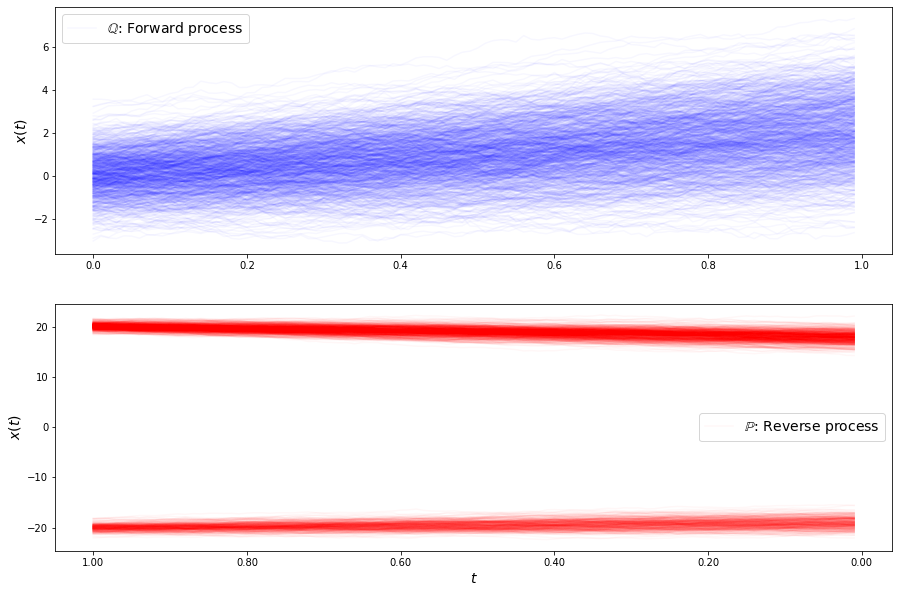

loss b 1635.294272476989
loss b 1644.3982574653298
loss b 1639.6420544484904
loss b 1632.2460311115267
loss b 1634.7281758653444
loss b 1642.363928693493
loss b 1627.87954843371
loss b 1631.6174170078398
loss b 1634.912495974046
loss b 1630.8202408663667
loss b 1614.5911170583904
loss b 1636.5948269497692
loss b 1639.4666172190682
loss b 1625.9834272993003
loss b 1619.8415809606918
loss b 1635.226050474395
loss b 1618.019459934426
loss b 1622.7327080265215
loss b 1617.458135802726
loss b 1618.8582653115943
loss b 1630.1243925861252
loss b 1632.3423967178005
loss b 1613.4951863047506
loss b 1631.3076418644648
loss b 1622.6572689565533
loss b 1624.6357000941878
loss b 1627.4806071304324
loss b 1622.1840150608757
loss b 1631.0303664682765
loss b 1619.2362894287494
loss b 1607.977137935113
loss b 1618.6886936126236
loss b 1614.6536304330061
loss b 1615.9376553284017
loss b 1610.7056034916884
loss b 1619.0141820940696
loss b 1622.845148400379
loss b 1615.8052710043476
loss b 1611.2568467858

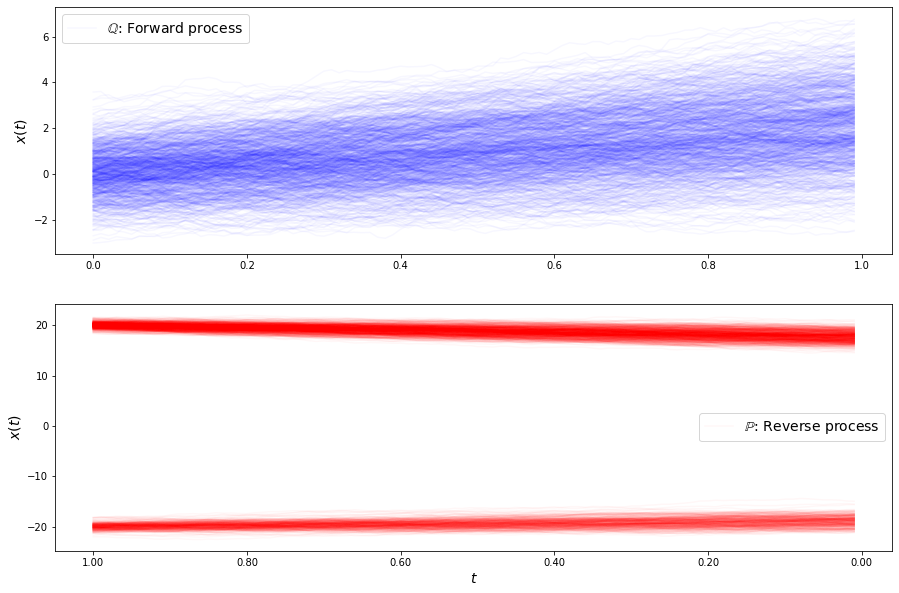

loss b 1619.7093565486698
loss b 1627.891854993043
loss b 1600.1023970551496
loss b 1621.267427894834
loss b 1607.4087469632902
loss b 1630.909434546004
loss b 1608.0191818639405
loss b 1609.6394598137654
loss b 1627.4180344637557
loss b 1614.9722753667265
loss b 1615.654165282766
loss b 1616.2419527510256
loss b 1596.716795526234
loss b 1594.2220992211364
loss b 1609.6117285404864
loss b 1610.4273124652548
loss b 1598.2438978048137
loss b 1606.9766865742358
loss b 1602.1105564887457
loss b 1609.2894349959233
loss b 1606.8772661400349
loss b 1589.9063761528093
loss b 1616.7835021972367
loss b 1597.2930448584784
loss b 1595.464938790747
loss b 1593.8612907862255
loss b 1606.5170786475232
loss b 1597.2930310257277
loss b 1592.7766092723896
loss b 1598.9561843911438
loss b 1604.3310843226989
loss b 1589.1382860953468
loss b 1602.9438924443393
loss b 1600.6624671286468
loss b 1614.086840486327
loss b 1600.971064836715
loss b 1590.4271151709909
loss b 1590.6632367005973
loss b 1587.28484286

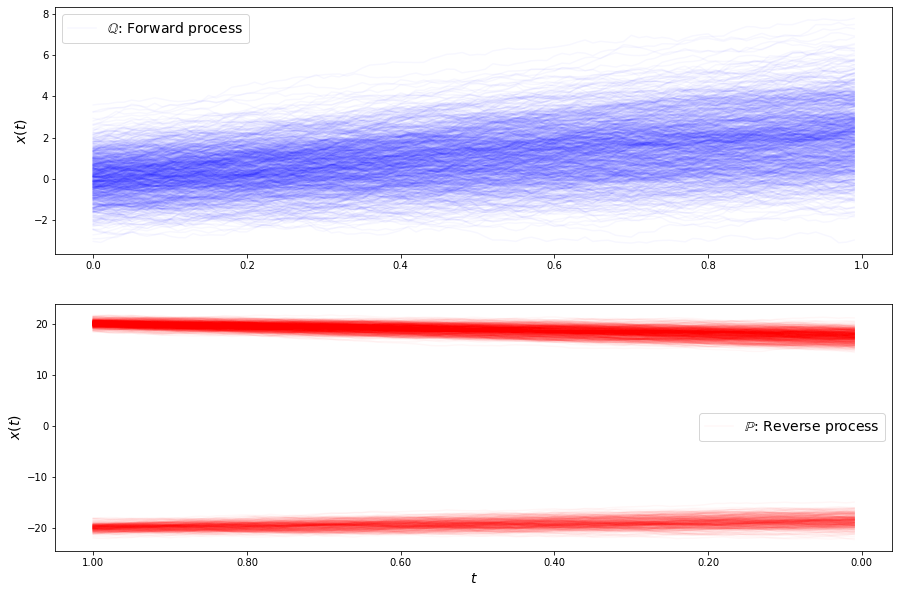

loss b 1601.1272098891943
loss b 1592.0190143150403
loss b 1583.010314848727
loss b 1589.9060036935198
loss b 1583.618158214601
loss b 1600.2091693741272
loss b 1584.7852459939452
loss b 1589.0605754412022
loss b 1594.4646057153336
loss b 1590.5369901555468
loss b 1596.1822210731461
loss b 1594.9716670733928
loss b 1588.2770859934592
loss b 1580.7187706200339
loss b 1596.0275140489698
loss b 1590.9732009151169
loss b 1579.7237493158307
loss b 1583.4639785378924
loss b 1585.152432931208
loss b 1587.1837996149782
loss b 1594.1052020420354
loss b 1598.0835486939147
loss b 1581.65039113838
loss b 1575.4711716767467
loss b 1577.632293035708
loss b 1586.816950958776
loss b 1566.9498445255765
loss b 1578.51008836201
loss b 1582.1407567128465
loss b 1587.3084346178723
loss b 1574.3353241490586
loss b 1575.4151446530102
loss b 1579.5626214021759
loss b 1570.5006275452079
loss b 1592.4281629843244
loss b 1580.1444644914495
loss b 1576.662300649841
loss b 1578.8114799019047
loss b 1571.4864158578

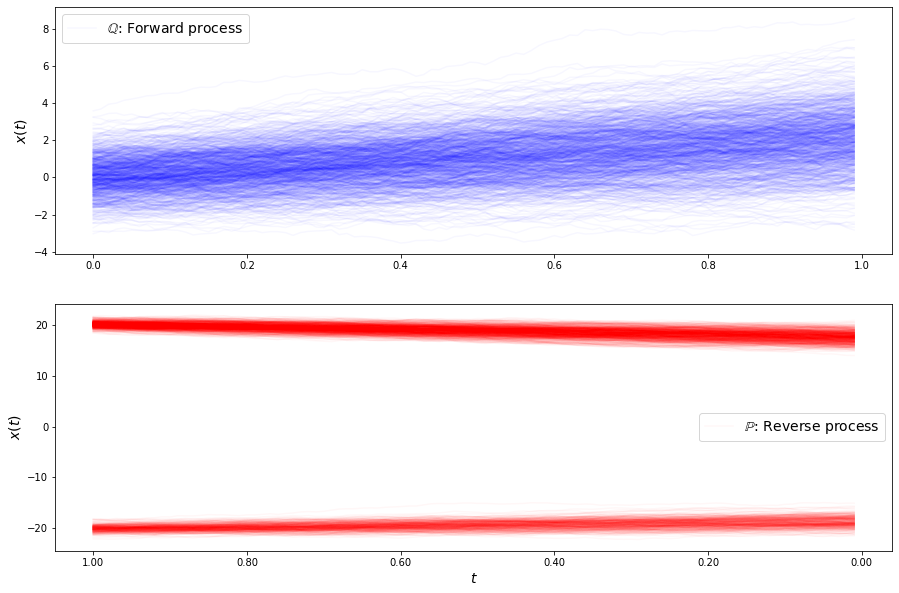

loss b 1581.1940674043124
loss b 1573.661825152331
loss b 1571.7247249804175
loss b 1579.4901756829581
loss b 1575.5599959279073
loss b 1582.5366981628567
loss b 1572.1173776827654
loss b 1566.9696006773852
loss b 1581.9542644857725
loss b 1565.3752610961876
loss b 1570.2993658131222
loss b 1569.2004938722625
loss b 1558.1258066378166
loss b 1568.9441600276925
loss b 1565.2950255116584
loss b 1568.595398951566
loss b 1566.5733469811723
loss b 1560.8656943296323
loss b 1577.2328041532296
loss b 1560.911134004528
loss b 1566.870096009721
loss b 1562.7249871047543
loss b 1568.508506482583
loss b 1557.3731934375426
loss b 1559.67438427511
loss b 1567.9295692034596
loss b 1559.076710446929
loss b 1564.4089647202088
loss b 1555.7264228364827
loss b 1561.8755063383016
loss b 1560.658508431848
loss b 1557.9688815558889
loss b 1565.936152880567
loss b 1551.7274518353556
loss b 1554.7051180319208
loss b 1553.4130313094572
loss b 1552.9885799288706
loss b 1558.398056548126
loss b 1556.59868251731

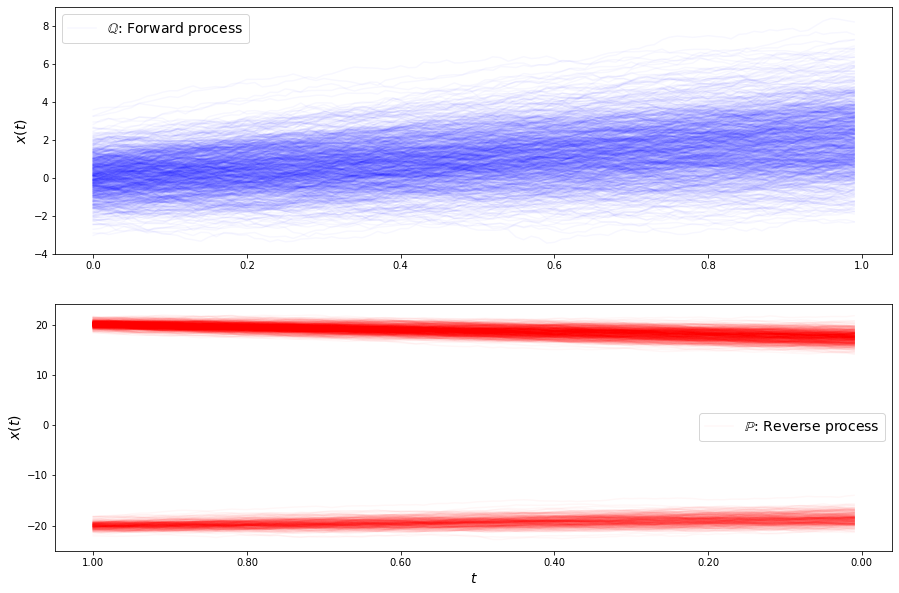

loss b 1557.682747525239
loss b 1541.953482747387
loss b 1536.6475306841576
loss b 1555.5310675439837
loss b 1559.51016422733
loss b 1549.2471556099028
loss b 1562.855791825168
loss b 1554.0290165683186
loss b 1549.2433627942544
loss b 1544.61096483165
loss b 1543.3389876179904
loss b 1561.7591558891934
loss b 1562.2128610450957
loss b 1547.4638662033085
loss b 1544.287531216667
loss b 1543.3215338571297
loss b 1555.6207855257978
loss b 1541.9314094763545
loss b 1539.443064239502
loss b 1551.9594280437252
loss b 1536.3963822280016
loss b 1540.0773321902564
loss b 1535.454986829194
loss b 1548.8386845741238
loss b 1539.0412587698509
loss b 1540.1756619629327
loss b 1541.4649545024859
loss b 1543.8185210779138
loss b 1531.148015880131
loss b 1536.0803187099038
loss b 1546.7725086253172
loss b 1527.3020555123214
loss b 1534.6229350897859
loss b 1545.2578089884191
loss b 1545.901418965842
loss b 1527.1762268505065
loss b 1547.7080684139657
loss b 1535.105842830981
loss b 1532.4505624679807

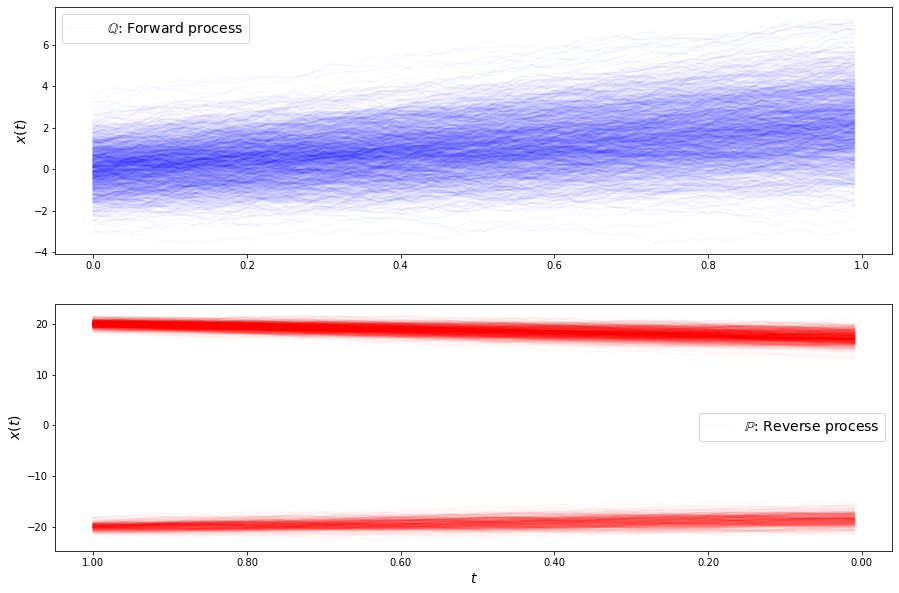

loss b 1529.7974780302266
loss b 1533.6780252548708
loss b 1535.1932525264428
loss b 1514.4090253694853
loss b 1534.9092521721254
loss b 1540.0543090239053
loss b 1524.8559626075125
loss b 1534.1477692953497
loss b 1522.4674898609017
loss b 1535.1099015482648
loss b 1538.758918332792
loss b 1529.0524529654253
loss b 1529.5923497402684
loss b 1525.1505857361979
loss b 1521.6130970967158
loss b 1540.1823698018043
loss b 1525.7962327619532
loss b 1521.166051416714
loss b 1527.7775973920643
loss b 1517.1126247054588
loss b 1532.5600606157925
loss b 1510.796160390623
loss b 1530.0181014894226
loss b 1531.0466378641227
loss b 1526.4600736054022
loss b 1521.8480374030173
loss b 1530.6404303382462
loss b 1531.37006496664
loss b 1515.3621420471181
loss b 1513.2432651303595
loss b 1522.110528104939
loss b 1522.1881082547227
loss b 1527.1075662394674
loss b 1526.734684648553
loss b 1525.3831159009028
loss b 1526.4092819756718
loss b 1505.1535620260245
loss b 1517.2150548189393
loss b 1518.1014495

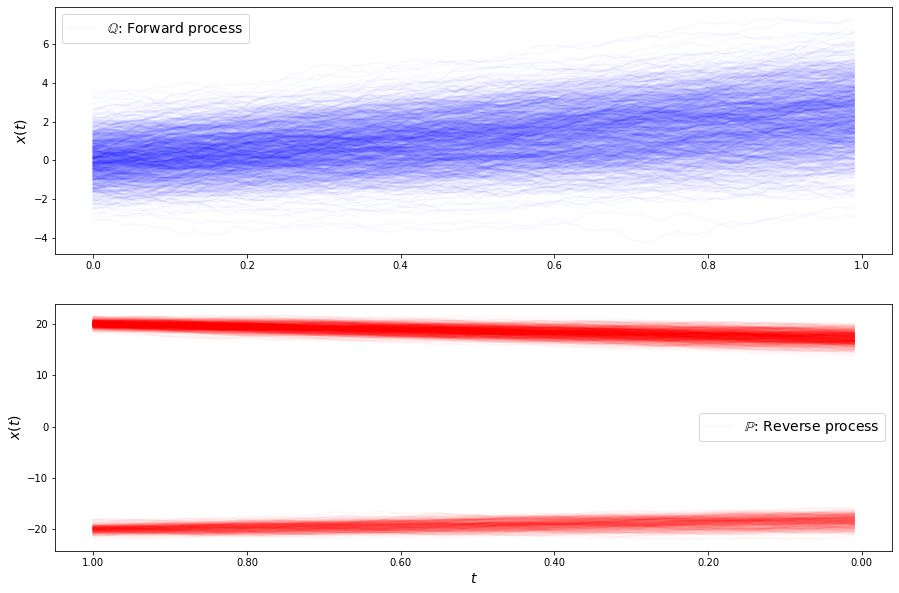

loss b 1511.8690640194136
loss b 1501.6678263748793
loss b 1512.6535167954303
loss b 1518.8447367991544
loss b 1519.1454295567617
loss b 1519.3155958794293
loss b 1526.9920940261793
loss b 1505.8735902312135
loss b 1524.4821338357647
loss b 1512.7147349979427
loss b 1524.656187385521
loss b 1502.9098170271448
loss b 1501.8270269877232
loss b 1515.8810266649593
loss b 1504.7452143837045
loss b 1501.1728514442043
loss b 1513.177194066539
loss b 1511.018769328374
loss b 1511.6853349073324
loss b 1504.6796348365624
loss b 1507.0620099807784
loss b 1498.7888737502064
loss b 1506.422300719371
loss b 1511.6279213647151
loss b 1501.5524207526673
loss b 1512.0190388378412
loss b 1509.8418373668217
loss b 1500.6049020475593
loss b 1503.257816204181
loss b 1503.6027475435242
loss b 1503.8388961169142
loss b 1497.0467487229466
loss b 1512.1362600830814
loss b 1513.4885165309802
loss b 1495.5455088295375
loss b 1501.4520467528805
loss b 1504.5645731518605
loss b 1495.0664978582236
loss b 1503.77592

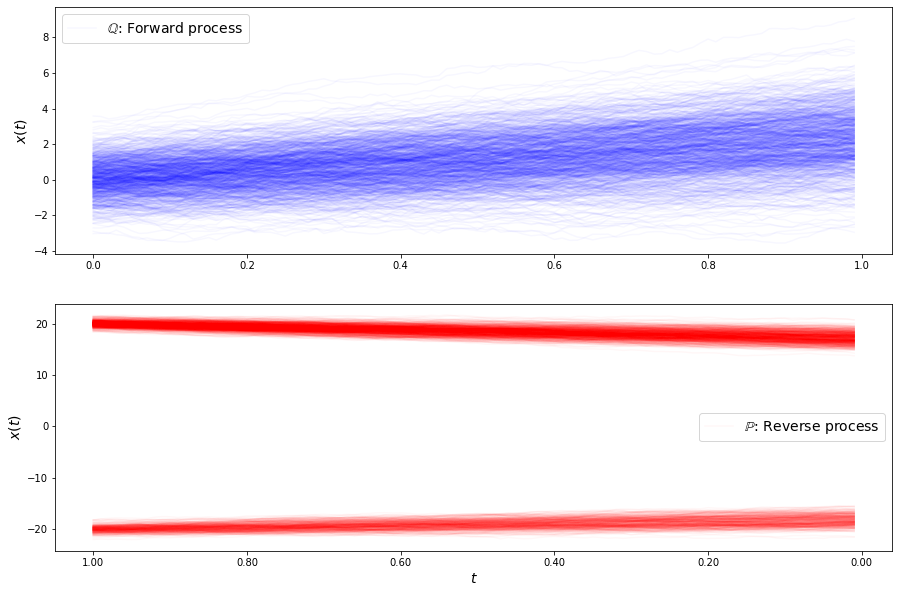

loss b 1498.3063667338822
loss b 1492.4719534593166
loss b 1487.0660848844827
loss b 1497.7550130217517
loss b 1502.8386500931288
loss b 1499.4312607746763
loss b 1511.6588846286966
loss b 1493.0421553058457
loss b 1503.6697657410116
loss b 1484.188581357897
loss b 1482.0756127017364
loss b 1499.445456256456
loss b 1497.570786095213
loss b 1497.244560979116
loss b 1492.90105526992
loss b 1498.3526606165203
loss b 1488.3643673119052
loss b 1482.3233496544983
loss b 1490.1602991194632
loss b 1501.926836736173
loss b 1484.5023342256152
loss b 1499.5016829648637
loss b 1484.6643022170922
loss b 1477.5819768441381
loss b 1483.7526130886338
loss b 1492.0475921204998
loss b 1499.5622656089215
loss b 1484.4089506479709
loss b 1475.6152348519304
loss b 1477.429189615072
loss b 1488.5326341097805
loss b 1489.7579210566596
loss b 1486.306664280145
loss b 1489.2698853656714
loss b 1479.8008854933776
loss b 1476.2058214261185
loss b 1482.1412345799843
loss b 1495.4196241279749
loss b 1485.315170696

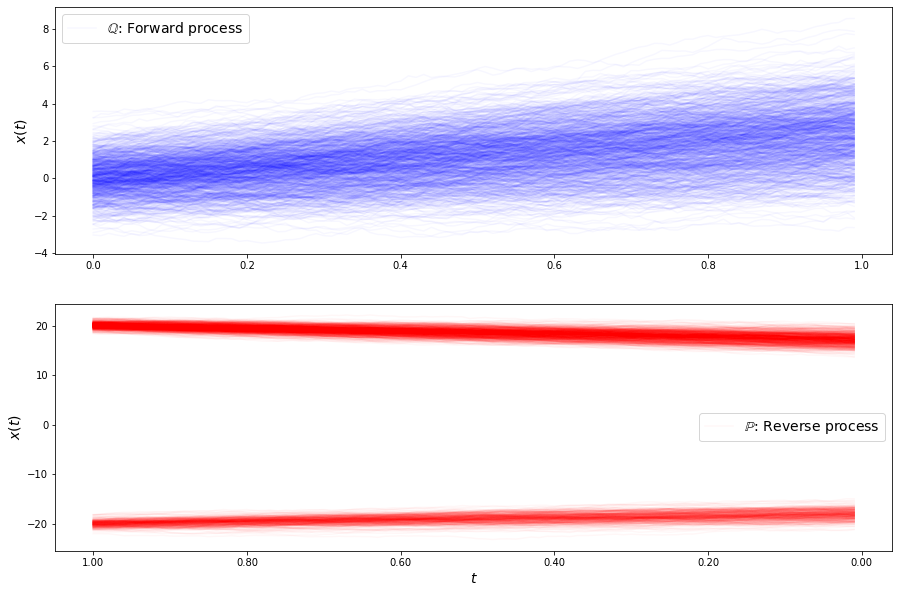

loss b 1477.847613855495
loss b 1492.5879804845795
loss b 1485.5556439904199
loss b 1478.1895510868799
loss b 1485.5337250170141
loss b 1473.254895439839
loss b 1467.4996161522376
loss b 1468.7140519472962
loss b 1484.313897370105
loss b 1476.3071708736193
loss b 1477.4901608781854
loss b 1469.280790350233
loss b 1488.7526671427424
loss b 1466.421260918283
loss b 1473.3606047591063
loss b 1473.3051948096854
loss b 1481.9106865433548
loss b 1495.8414668052894
loss b 1468.1037787862692
loss b 1458.4780024802174
loss b 1470.568081540925
loss b 1468.5459617912825
loss b 1478.1655187515532
loss b 1462.4567351141354
loss b 1472.7810627086053
loss b 1469.6360355497477
loss b 1466.0937306408928
loss b 1477.6403120948398
loss b 1465.75849699178
loss b 1481.677388926676
loss b 1461.8638025191437
loss b 1475.5007071027449
loss b 1466.4372719693395
loss b 1461.7557542928564
loss b 1463.6376729957149
loss b 1461.64471556596
loss b 1466.6269947612402
loss b 1474.2672893637791
loss b 1466.32547019707

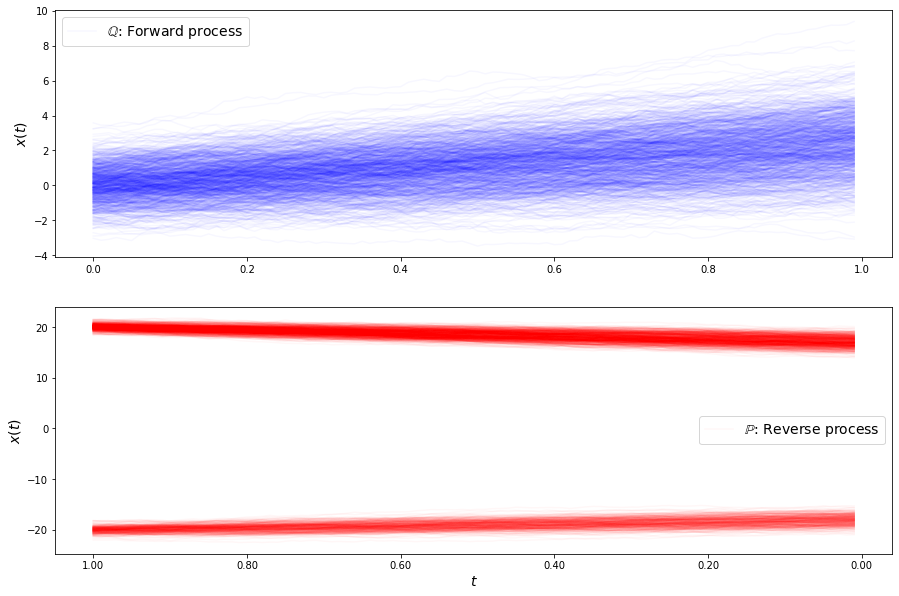

loss b 1475.5694103430558
loss b 1464.745161824179
loss b 1467.1029520438935
loss b 1468.5084926924756
loss b 1457.872729290815
loss b 1458.0707931991271
loss b 1469.183746176863
loss b 1461.5535758850465
loss b 1456.2614593520727
loss b 1460.6962759645066
loss b 1457.9153326967676
loss b 1467.4604389580616
loss b 1466.2739711730576
loss b 1461.5127277967247
loss b 1459.4711469921258
loss b 1461.4528072941152
loss b 1461.187466136263
loss b 1458.3922238980288
loss b 1461.56519927509
loss b 1469.3693007107952
loss b 1452.8496941571589
loss b 1458.184111328909
loss b 1456.0157474485052
loss b 1455.7969072144083
loss b 1458.3837767861623
loss b 1456.7997014031566
loss b 1454.89278217403
loss b 1454.3004435852768
loss b 1464.278635590501
loss b 1443.7064130486194
loss b 1456.9141233889131
loss b 1453.2745159341853
loss b 1447.2281530315583
loss b 1454.418046233123
loss b 1461.0795548374447
loss b 1451.1072224035463
loss b 1460.735239801474
loss b 1452.604082888126
loss b 1444.9495106345014

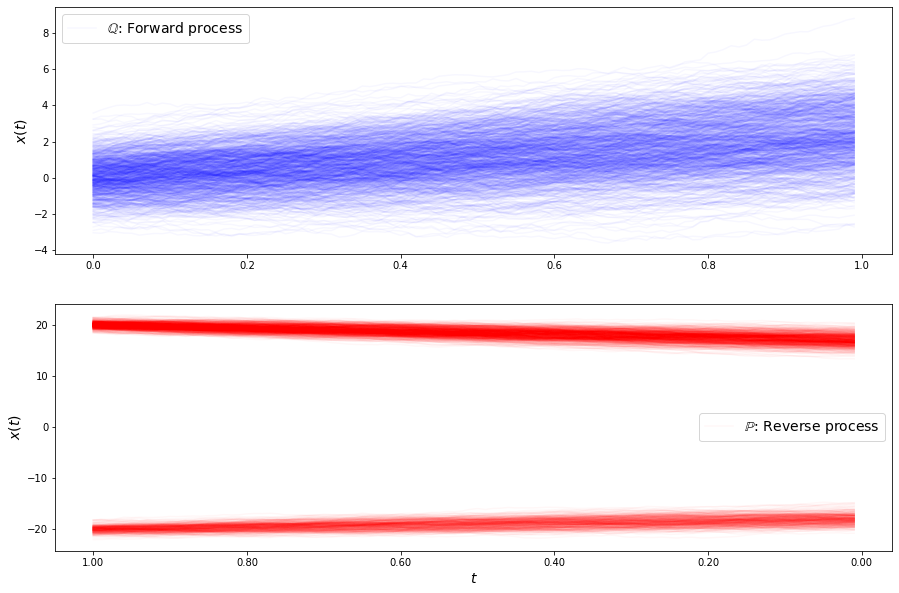

loss b 1465.5297541611783
loss b 1450.2621391893806
loss b 1438.9778672721918
loss b 1456.6217967222674
loss b 1453.757579941386
loss b 1447.531525668009
loss b 1446.7375499001334
loss b 1443.3909709205552
loss b 1453.7178172412505
loss b 1450.7499824764732
loss b 1439.2138256666985
loss b 1438.05220272143
loss b 1436.0231842733845
loss b 1439.3565380448856
loss b 1448.6168177129084
loss b 1448.1331406116053
loss b 1448.3315703318917
loss b 1446.5438773074143
loss b 1443.4669010504645
loss b 1447.457476715543
loss b 1442.5446596789188
loss b 1438.1928811102148
loss b 1444.9316901308534
loss b 1440.4853820701387
loss b 1445.3052463491297
loss b 1440.6421554211513
loss b 1438.8500880635847
loss b 1435.319221771293
loss b 1437.8673313983174
loss b 1442.281944162898
loss b 1449.2943928927389
loss b 1441.843832403129
loss b 1438.175742897058
loss b 1430.5964551251068
loss b 1428.8526072314705
loss b 1441.9414848262345
loss b 1449.6125799135434
loss b 1450.3278611236515
loss b 1437.694994296

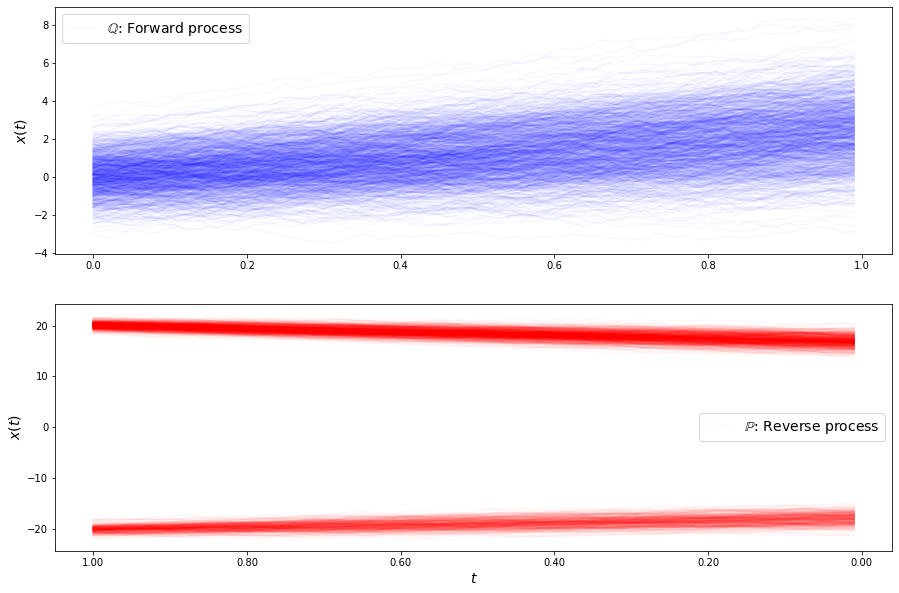

loss b 1437.6932491202635
loss b 1452.5699130566975
loss b 1430.8753573567706
loss b 1433.2921689155528
loss b 1431.1429012211509
loss b 1438.9402475190793
loss b 1444.047272287753
loss b 1431.9057712480464
loss b 1420.724515862634
loss b 1431.3968169335774
loss b 1444.2197893520517
loss b 1420.5816575184672
loss b 1437.6045710147655
loss b 1432.4163312475473
loss b 1433.6800028715002
loss b 1423.9142205641153
loss b 1423.5211071109284
loss b 1433.025300347991
loss b 1418.3817606446896
loss b 1418.070560165069
loss b 1431.6002447414294
loss b 1439.1982597295382
loss b 1428.08324971253
loss b 1421.778927550882
loss b 1433.8632921680207
loss b 1430.2430060134534
loss b 1426.220400545565
loss b 1426.0078509509883
loss b 1420.460725486074
loss b 1422.2983640287707
loss b 1427.5140543906386
loss b 1420.1332707429917
loss b 1429.54793895732
loss b 1426.3721108481102
loss b 1423.7369296393483
loss b 1419.9047983624341
loss b 1421.535676760135
loss b 1404.9216124147438
loss b 1422.860859919555

In [ ]:
torch.autograd.set_detect_anomaly(True)
c.fit(150, 39, burn_iterations=5, plot=True)

In [ ]:
plt.plot(c.loss_f)
plt.show()
plt.plot(c.loss_b)

In [224]:
X = torch.linspace(-10, 10, 100).reshape(100, 1)
t = torch.ones(100).reshape(100, 1)
Xt = torch.cat((X,t), dim=1).cuda().double().requires_grad_()
print(Xt.shape)

torch.autograd.functional.jacobian(c.b_forward.forward, Xt).shape

torch.Size([100, 2])


torch.Size([100, 1, 100, 2])

In [225]:
B = c.b_forward.forward(Xt)

In [228]:
c.b_forward.forward

test = torch.autograd.grad(B, Xt, torch.ones_like(B), retain_graph=True)[0].shape

torch.Size([100, 2])

In [243]:
xx = Xt[0,:].reshape(1,-1).double().cuda().requires_grad_()

test2 = c.b_forward.forward(xx)
test2

tensor([[-0.1342]], device='cuda:0', dtype=torch.float64,
       grad_fn=<AddmmBackward>)

In [244]:
print(torch.autograd.grad(test2, xx, torch.ones_like(test2), retain_graph=True))

(tensor([[-0.0120, -0.5032]], device='cuda:0', dtype=torch.float64),)


In [ ]:
def compute_jacobian(f, x, output_dims):
    '''
    Normal:
        f: input_dims -> output_dims
    Jacobian mode:
        f: output_dims x input_dims -> output_dims x output_dims
    '''
    repeat_dims = tuple(output_dims) + (1,) * len(x.shape)
    jac_x = x.detach().repeat(*repeat_dims)
    jac_x.requires_grad_()
    jac_y = f(jac_x)
    
    ml = torch.meshgrid([torch.arange(dim) for dim in output_dims])
    index = [m.flatten() for m in ml]
    gradient = torch.zeros(output_dims + output_dims)
    gradient.__setitem__(tuple(index)*2, 1)
    
    jac_y.backward(gradient)
        
    return jac_x.grad.data